In [2]:
# 获取URL数据（北京地铁数据）：http://map.amap.com/service/subway?_1469083453978&srhdata=1100_drw_beijing.json
# 你需要用到以下的包

import requests
import re
import numpy as np
r = requests.get('http://map.amap.com/service/subway?_1469083453978&srhdata=1100_drw_beijing.json')
#r.text

In [3]:
def get_lines_stations_info(text):
    # 请在这里写上你的代码
    # 遍历text格式数据，组成地点数据结构
    # 所有线路信息的dict：key：线路名称；value：站点名称list
    lines_info = {}
    # 所有站点信息的dict：key：站点名称；value：站点坐标(x,y)
    stations_info = {}
    lines_list = text.split("\"st\"")
    for line in lines_list:
        find_line = re.findall("\"ln\":\"(\w+)\"",line)  #查找线路
        if find_line:   
            find_station = re.findall("\"n\":\"(\w+)\"",line)  #查找该线路的所有站点
            #find_sl = re.findall("\"p\":\"\d+ \d+\"",line)
            find_sl = re.findall("\"sl\":\"(\d+.\d+),(\d+.\d+)\"",line)  #查找经纬度
            for i in range(len(find_station)):
                stations_info[find_station[i]] = tuple(map(float,find_sl[i]))
            lines_info[find_line[0]] = find_station

    return lines_info,stations_info
lines_info, stations_info = get_lines_stations_info(r.text)
#print(lines_info)
#stations_info

In [4]:
# 根据线路信息，建立站点邻接表dict
def get_neighbor_info(lines_info):
    neighbor_info = {}
    stations = set()
    
    for key in lines_info.keys():
        stations.update(lines_info[key])
    
    for station in stations:
        next_station = {}
        for line in lines_info:
            if station in lines_info[line]:
                station_index = lines_info[line].index(station)
                if station_index == 0:
                    next_station[lines_info[line][1]] = line
                elif station_index == len(lines_info[line])-1:
                    next_station[lines_info[line][station_index-1]] = line
                else:
                    next_station[lines_info[line][station_index-1]] = line
                    next_station[lines_info[line][station_index+1]] = line
        neighbor_info[station] = next_station
     
    return neighbor_info
        
neighbor_info = get_neighbor_info(lines_info)
#neighbor_info

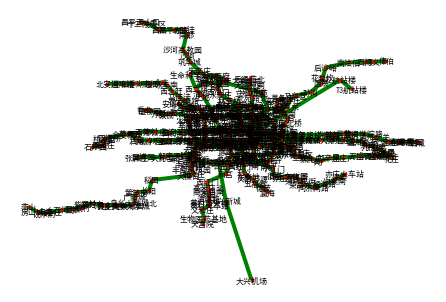

In [5]:
# 画地铁图
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

# 如果汉字无法显示，请参照
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 


graph = nx.Graph(neighbor_info)
#graph.add_nodes_from(list(get_neighbor_info))
nx.draw(graph, stations_info, style='solid', font_size=8, node_color='r', edge_color='g', width=4, with_labels = True, node_size=7)

# matplotlib.rcParams['font.family']='sans-serif'

In [6]:
#最小换乘

#  你也可以使用第二种算法：没有启发函数的简单宽度优先

def get_path_BFS(lines_info, neighbor_info, from_station, to_station):
    # 搜索策略：以站点数量为cost（因为车票价格是按站算的）
    # 这种情况下，站点间的坐标距离难以转化为可靠的启发函数，所以只用简单的BFS算法
    # 由于每深一层就是cost加1，所以每层的cost都相同，算和不算没区别，所以省略
    # 检查输入站点名称
    if from_station == to_station:
        return [from_station]

    pathes = [ [ from_station, ('',0)] ]
    
    while(pathes):
        path = pathes.pop(0)
        froniter = path[-2]
        previous_line, transfer_times = path[-1]
        
        successors = neighbor_info[froniter]
        
        for station in successors:
            if station in path:continue
            
            linechange = transfer_times
            if previous_line != successors[station]:
                linechange += 1
                
            new_path = path[:-1] + [station, (successors[station],linechange)]
            if station == to_station:
                return new_path[:-1]
            else:
                pathes.append(new_path)
                pathes.sort(key=lambda path:path[-1][-1])

print(get_path_BFS(lines_info, neighbor_info, '顺义', '天通苑'))


['顺义', '石门', '南法信', '后沙峪', '花梨坎', '国展', '孙河', '马泉营', '崔各庄', '望京东', '望京', '望京西', '关庄', '大屯路东', '北苑路北', '立水桥南', '立水桥', '天通苑南', '天通苑']


In [53]:
#  你也可以使用第二种算法：没有启发函数的简单宽度优先

def get_path_BFS(lines_info, neighbor_info, from_station, to_station):
    if from_station == to_station:
        return [from_station]
    
    pathes = [ [ from_station] ]
    
    while(pathes):
        path = pathes.pop(0)
        froniter = path[-1]
        
        successors = neighbor_info[froniter]
        
        for station in successors:
            if station in path:continue
            
            new_path = path + [station]
            #print(new_path)
            if station == to_station:
                return new_path
            else:
                pathes.append(new_path)

print(get_path_BFS(lines_info, neighbor_info, '人民大学', '青年路'))

['人民大学', '魏公村', '国家图书馆', '动物园', '西直门', '车公庄', '平安里', '北海北', '南锣鼓巷', '东四', '朝阳门', '东大桥', '呼家楼', '金台路', '十里堡', '青年路']
